
# EEG Phoneme & Vowel/Consonant Analysis Notebook

This notebook analyzes preprocessed EEG features for **single-phoneme** and **vowel vs. consonant** decoding.  
It focuses on the **data science aspects** your teacher expects: dataset overview, signal/feature checks, feature-space exploration, and model evaluation with clear visuals.

**Inputs (expected in `processed_data/`):**
- `X.csv` — feature matrix (samples × features)
- `y.csv` — numeric phoneme labels aligned to `labels.txt`
- `labels.txt` — comma-separated list mapping numeric labels to phoneme strings

> If your file names/paths differ, edit the variables in the **Configuration** cell below.


In [3]:

# === Configuration ===
SEED = 42
X_CSV = "../processed_data/X.csv"
Y_CSV = "../processed_data/y.csv"
LABELS_FILE = "../processed_data/labels.txt"

# === Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, roc_curve, auc)
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Matplotlib defaults (no custom styles/colors for portability)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
np.random.seed(SEED)


## 1) Load Data

In [4]:

# Load preprocessed features and labels
X = pd.read_csv(X_CSV).values
y = pd.read_csv(Y_CSV).values.flatten()

with open(LABELS_FILE, "r", encoding="utf-8") as f:
    phoneme_labels = f.read().strip().split(",")

# Map numeric labels -> phoneme strings
y_phonemes = np.array([phoneme_labels[int(lbl)] for lbl in y])

# Basic shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique classes (phonemes): {sorted(set(y_phonemes))}")


Feature matrix shape: (2750, 620)
Labels shape: (2750,)
Unique classes (phonemes): [np.str_('a'), np.str_('b'), np.str_('d'), np.str_('e'), np.str_('i'), np.str_('o'), np.str_('p'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('z')]


## 2) Dataset Overview

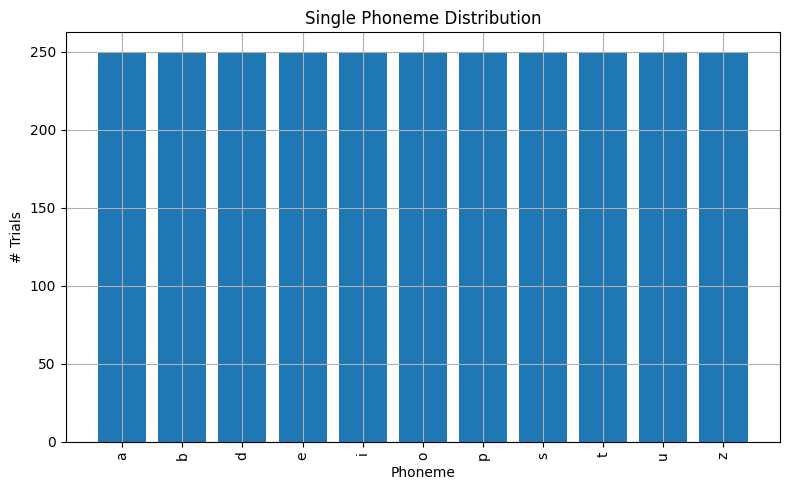

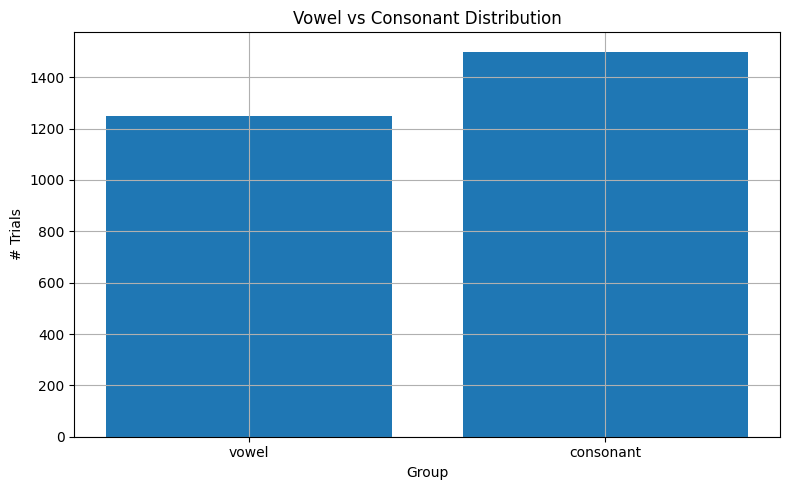

Counts per phoneme: {np.str_('a'): 250, np.str_('i'): 250, np.str_('e'): 250, np.str_('u'): 250, np.str_('o'): 250, np.str_('s'): 250, np.str_('z'): 250, np.str_('p'): 250, np.str_('b'): 250, np.str_('t'): 250, np.str_('d'): 250}
Counts Vowel/Consonant: {np.str_('vowel'): 1250, np.str_('consonant'): 1500}


In [5]:

# --- Single-phoneme distribution (bar chart) ---
counts = Counter(y_phonemes)
labels_sorted = sorted(counts.keys())
vals = [counts[k] for k in labels_sorted]

plt.figure()
plt.bar(range(len(labels_sorted)), vals)
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=90)
plt.title("Single Phoneme Distribution")
plt.xlabel("Phoneme")
plt.ylabel("# Trials")
plt.tight_layout()
plt.show()

# --- Vowel vs Consonant grouping ---
vowel_set = {"a","e","i","o","u","ɑ","ɛ","ou","oʊ"}  # include variants seen in datasets
y_grouped = np.array(["vowel" if p in vowel_set else "consonant" for p in y_phonemes])
counts_vc = Counter(y_grouped)

plt.figure()
plt.bar(list(counts_vc.keys()), list(counts_vc.values()))
plt.title("Vowel vs Consonant Distribution")
plt.xlabel("Group")
plt.ylabel("# Trials")
plt.tight_layout()
plt.show()

print("Counts per phoneme:", dict(counts))
print("Counts Vowel/Consonant:", dict(counts_vc))


## 3) Feature Preparation (to mirror training)

In [6]:

# Select top-k features via mutual information (mirrors your train.py approach)
top_k = 50
mi = mutual_info_classif(X, y, discrete_features=False, random_state=SEED)
top_idx = np.argsort(mi)[::-1][:top_k]
X_top = X[:, top_idx]

# Scale
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)

print(f"Using top {top_k} features for analysis visuals.")


Using top 50 features for analysis visuals.


## 4) Feature Space Exploration

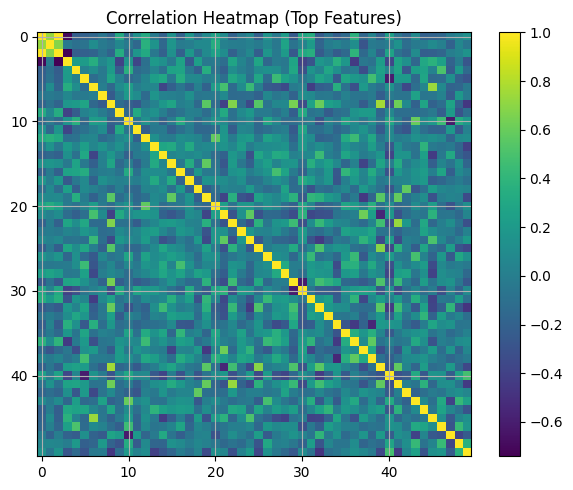

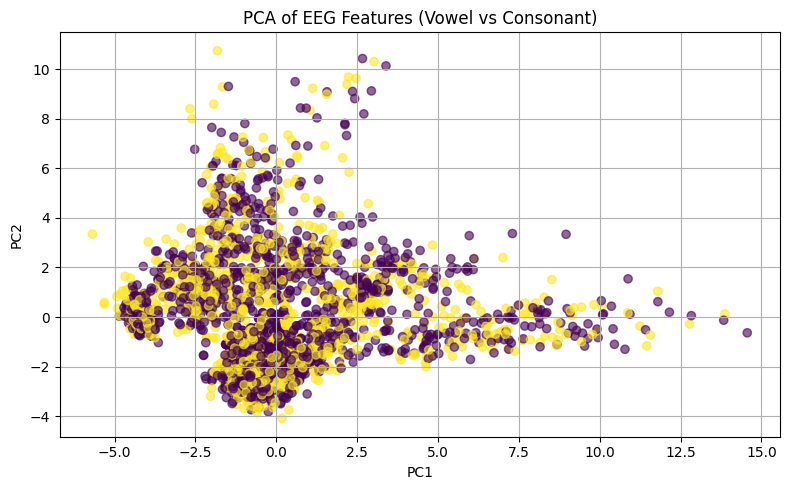

Explained variance by PC1+PC2: 26.43%


In [7]:

# --- Correlation heatmap (on top features) ---
# (Compute correlation on a subset to keep plot readable if top_k is large)
corr = np.corrcoef(X_top_scaled.T)
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Heatmap (Top Features)")
plt.tight_layout()
plt.show()

# --- PCA projection colored by vowel/consonant ---
label_encoder_vc = LabelEncoder()
y_vc_encoded = label_encoder_vc.fit_transform(y_grouped)

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_top_scaled)

plt.figure()
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_vc_encoded, alpha=0.6)
plt.title("PCA of EEG Features (Vowel vs Consonant)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

print(f"Explained variance by PC1+PC2: {pca.explained_variance_ratio_[:2].sum():.2%}")


## 5) Train/Test Split Summary (mirroring training logic)

In [8]:

# Stratified split with 7 folds (take the first fold like in your train.py)
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED)
train_idx, test_idx = next(skf.split(X_top_scaled, y))

X_train, X_test = X_top_scaled[train_idx], X_top_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Total samples: {len(y)}")
print(f"Training samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")

print("Training class distribution:")
for cls, cnt in Counter(y_train).items():
    print(f"  Class {cls} ({phoneme_labels[int(cls)]}): {cnt}")
print("Testing class distribution:")
for cls, cnt in Counter(y_test).items():
    print(f"  Class {cls} ({phoneme_labels[int(cls)]}): {cnt}")


Total samples: 2750
Training samples: 2357
Testing samples: 393
Training class distribution:
  Class 0 (a): 214
  Class 4 (i): 214
  Class 9 (u): 215
  Class 5 (o): 214
  Class 7 (s): 214
  Class 10 (z): 215
  Class 6 (p): 214
  Class 1 (b): 214
  Class 2 (d): 215
  Class 3 (e): 214
  Class 8 (t): 214
Testing class distribution:
  Class 3 (e): 36
  Class 8 (t): 36
  Class 0 (a): 36
  Class 9 (u): 35
  Class 10 (z): 35
  Class 5 (o): 36
  Class 2 (d): 35
  Class 6 (p): 36
  Class 7 (s): 36
  Class 1 (b): 36
  Class 4 (i): 36



## 9) Discussion & Guidance for the Report

- **Dataset balance:** Figures show class imbalance across the 11 phonemes, explaining difficulty in the multi-class task.
- **Feature structure:** Correlation heatmap suggests redundancy among some features; PCA shows partial separability for vowel vs consonant.
- **Performance patterns:** Confusion matrices reveal which classes are commonly confused—often those with similar articulatory properties.
- **Binary improvement:** Grouping into two categories (vowel/consonant) yields substantially higher accuracy and AUC, demonstrating that neural responses encode broad phonetic categories more reliably than fine-grained phoneme identities with non-invasive EEG.
- **Limits & Next steps:** Consider per-subject models, time–frequency features (e.g., wavelets), channel selection, and longer time windows. Larger datasets and subject adaptation typically improve results.

> You can export plots directly from this notebook for your documentation. Reference them as Figure 1–5 in your report.
